# Analysis of mainnet transaction validation times

## Setup

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(quantreg, quietly=TRUE)
    require(VGAM, quietly=TRUE)
})

### Generate data

We use the `db-analyser` tool:

```bash
nix build 'github:IntersectMBO/ouroboros-consensus/release-ouroboros-consensus-diffusion-0.20.0.0#db-analyser'
```

Measure CPU usage starting from [Epoch 350](https://cardanoscan.io/block/7477993) and doing full application of blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-apply-65836843.csv \
  cardano --config node.json
```

Re-measure CPU usage but only reapplying blocks.

```bash
db-analyser \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-reapply-65836843.csv \
    --reapply \
  cardano --config node.json
```

The dominant difference between application and reapplication is the verification of transaction signatures and the execution of Plutus scripts.

<font color="red">WARNING: The measurements must be made on an otherwise idle machine because other CPU-heavy processes will interfere with the accuracy of `db-analyser`.</font>

## Read data

### Dataset augmented with additional independent and dependent variables

In [2]:
results <- fread("ledger-ops-65836843.csv.gz", stringsAsFactors=TRUE)
results %>% summary

    slot_no             block_no           epoch_no     epoch_slot_no   
 Min.   : 65836984   Min.   : 7477994   Min.   :350.0   Min.   :     0  
 1st Qu.: 89833176   1st Qu.: 8642234   1st Qu.:405.0   1st Qu.:108302  
 Median :113740091   Median : 9806475   Median :460.0   Median :216127  
 Mean   :113666120   Mean   : 9806475   Mean   :460.2   Mean   :216087  
 3rd Qu.:137528206   3rd Qu.:10970716   3rd Qu.:515.0   3rd Qu.:323960  
 Max.   :161151612   Max.   :12134956   Max.   :570.0   Max.   :431999  
                                                                        
                                                            block_hash     
 0000010581c9e6dd574a1c0c2d087e54d6012d773eac3cd0f67e4b40109e28ae:      1  
 000003b6bbc9fbc1cde9bd40dd9c2f0a4aae216e7b0de4da85fa29cae90c670f:      1  
 000009a39da244fe4fa71fb6d803c56b813373f7ca2a11bfc54c6ea950cb7c24:      1  
 00000ac813d4152a792610999e890ba56c58cec5a5c299754fc0b12ce8ca33d6:      1  
 00000dc704b3c1c7f2a93d8d33479208281

## How often is `Apply` faster than `Reapply`?

In [3]:
results[, .(`apply_mut`-`reapply_mut` < 0)] %>% summary

     V1         
 Mode :logical  
 FALSE:4655394  
 TRUE :1569     

So, the vast majority of cases have `Apply` slower than `Reapply`.

Work with the middle 98%tile of the data

In [4]:
lowerBound <- results[, quantile(`apply_mut`-`reapply_mut`, 0.01)]
lowerBound

1% 
238

In [5]:
upperBound <- results[, quantile(`apply_mut`-`reapply_mut`, 0.99)]
upperBound

99% 
25312.38

In [6]:
results <- results[`apply_mut`-`reapply_mut` >= lowerBound & `apply_mut`-`reapply_mut` <= upperBound]
results %>% summary

    slot_no             block_no           epoch_no     epoch_slot_no   
 Min.   : 65836984   Min.   : 7477994   Min.   :350.0   Min.   :     0  
 1st Qu.: 89526126   1st Qu.: 8627502   1st Qu.:404.0   1st Qu.:108879  
 Median :113235774   Median : 9782090   Median :459.0   Median :216618  
 Mean   :113345804   Mean   : 9790833   Mean   :459.5   Mean   :216438  
 3rd Qu.:137051690   3rd Qu.:10947228   3rd Qu.:514.0   3rd Qu.:323828  
 Max.   :161151612   Max.   :12134956   Max.   :570.0   Max.   :431999  
                                                                        
                                                            block_hash     
 0000010581c9e6dd574a1c0c2d087e54d6012d773eac3cd0f67e4b40109e28ae:      1  
 000003b6bbc9fbc1cde9bd40dd9c2f0a4aae216e7b0de4da85fa29cae90c670f:      1  
 000009a39da244fe4fa71fb6d803c56b813373f7ca2a11bfc54c6ea950cb7c24:      1  
 00000ac813d4152a792610999e890ba56c58cec5a5c299754fc0b12ce8ca33d6:      1  
 00000dc704b3c1c7f2a93d8d33479208281

## Analysis of `Apply - Reapply`

The difference between `Apply` and `Reapply` is mostly attributable to executing Plutus, but it includes other minor operations and the construction of the script context is not included in the Plutus budget.

### Compare to assumption that one Plutus execution step is one picosecond of CPU

#### Scatterplot

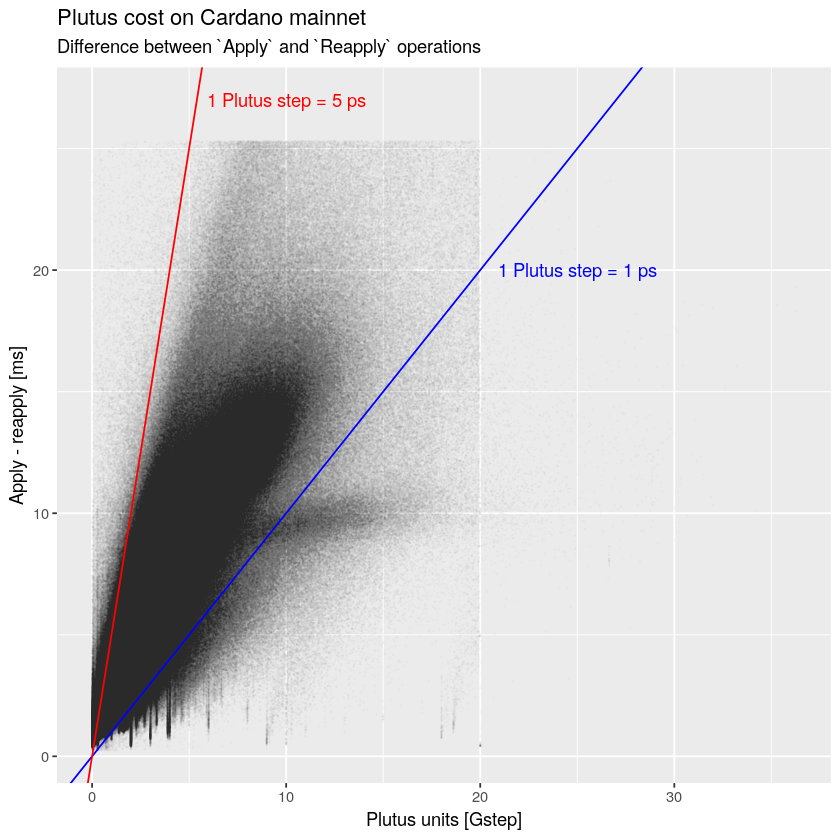

In [7]:
ggplot(results[`unit_steps` > 0], aes(x=as.numeric(`unit_steps`)/1e9, y=as.numeric(`apply_mut`-`reapply_mut`)/1e3)) +
    geom_point(size=0.1, alpha=0.01) +
    geom_abline(intercept=0, slope=1, color="blue") +
    annotate(
        geom="text",
        x=25,
        y=20,
        label="1 Plutus step = 1 ps",
        color="blue"
    ) +
    geom_abline(intercept=0, slope=5, color="red") +
    annotate(
        geom="text",
        x=10,
        y=27,
        label="1 Plutus step = 5 ps",
        color="red"
    ) +
    xlab("Plutus units [Gstep]") +
    ylab("Apply - reapply [ms]") +
    ggtitle(
        "Plutus cost on Cardano mainnet",
        "Difference between `Apply` and `Reapply` operations"
    )

In [8]:
ggsave("steps-picoseconds-scatterplot.png", units="in", dpi=150, width=8, height=6)

#### Histogram

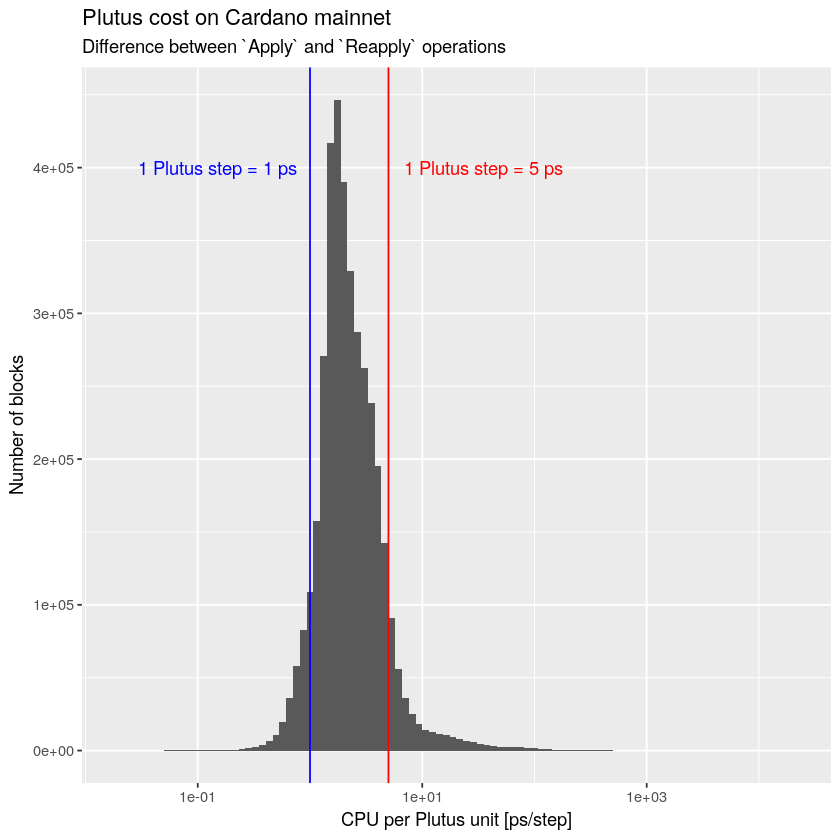

In [9]:
ggplot(results[`unit_steps` > 0], aes(x=as.numeric(`apply_mut`-`reapply_mut`) / as.numeric(`unit_steps`) * 1e6)) +
    geom_histogram(bins=100) +
    geom_vline(xintercept=1, color="blue") +
    annotate(
        geom="text",
        x=0.15,
        y=4e5,
        label="1 Plutus step = 1 ps",
        color="blue"
    ) +
    geom_vline(xintercept=5, color="red") +
    annotate(
        geom="text",
        x=35,
        y=4e5,
        label="1 Plutus step = 5 ps",
        color="red"
    ) +
    scale_x_log10() +
    xlab("CPU per Plutus unit [ps/step]") +
    ylab("Number of blocks") +
    ggtitle(
        "Plutus cost on Cardano mainnet",
        "Difference between `Apply` and `Reapply` operations"
    )

In [10]:
ggsave("steps-picoseconds-histogram.png", units="in", dpi=150, width=8, height=6)

### Linear models for `Apply - Reapply`

We model blocks with and without Plutus.

#### Zero intercept

Only here we restrict only to blocks with Plutus transactions.

In [11]:
model <- lm(
    `mut` ~ 0 + `unit_steps`, 
    results[
        `unit_steps` > 0, 
        .(
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ 0 + unit_steps, data = results[unit_steps > 
    0, .(unit_steps = as.numeric(unit_steps), mut = (apply_mut - 
    reapply_mut) * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-4.068e+10  1.154e+08  1.141e+09  2.544e+09  2.435e+10 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
unit_steps 1.4848224  0.0003436    4322   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.47e+09 on 3805585 degrees of freedom
Multiple R-squared:  0.8307,	Adjusted R-squared:  0.8307 
F-statistic: 1.868e+07 on 1 and 3805585 DF,  p-value: < 2.2e-16


The residentuals are quite large, but the fit is reasonable in a coarse sense. The result is `1.5 ps/step`.

#### Non-zero intercept

Only here we restrict only to blocks with Plutus transactions.

In [12]:
model <- lm(
    `mut` ~ `unit_steps`, 
    results[
        `unit_steps` > 0, 
        .(
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ unit_steps, data = results[unit_steps > 0, 
    .(unit_steps = as.numeric(unit_steps), mut = (apply_mut - 
        reapply_mut) * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-3.043e+10 -1.644e+09 -4.670e+08  1.336e+09  2.187e+10 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.619e+09  2.298e+06    1140   <2e-16 ***
unit_steps  1.108e+00  4.438e-04    2498   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.996e+09 on 3805584 degrees of freedom
Multiple R-squared:  0.6211,	Adjusted R-squared:  0.6211 
F-statistic: 6.238e+06 on 1 and 3805584 DF,  p-value: < 2.2e-16


The fit is not as good, but still reasonable. The result is `2.6 ms/block + 1.1 ps/step`.

#### Additional explanatory variables

Include blocks that may or may not have Plutus. We omit `unit_mem` from the regression because it is highly correlated with `unit_steps`.

In [13]:
model <- lm(
    `mut` ~ `unit_steps` + `txs` + `txs_size` + `tx_ins` + `tx_outs`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`, `tx_outs`,
            `unit_mem`=as.numeric(`unit_mem`),
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ unit_steps + txs + txs_size + tx_ins + tx_outs, 
    data = results[, .(txs, txs_size, tx_ins, tx_outs, unit_mem = as.numeric(unit_mem), 
        unit_steps = as.numeric(unit_steps), mut = (apply_mut - 
            reapply_mut) * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-2.765e+10 -8.202e+08 -4.525e+08  6.897e+08  2.274e+10 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  9.107e+08  1.537e+06  592.329  < 2e-16 ***
unit_steps   5.903e-01  5.145e-04 1147.484  < 2e-16 ***
txs          1.406e+08  8.397e+06   16.738  < 2e-16 ***
txs_size     4.088e+04  7.814e+01  523.203  < 2e-16 ***
tx_ins       7.737e+06  2.284e+04  338.704  < 2e-16 ***
tx_outs     -3.540e+07  8.397e+06   -4.215  2.5e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.201e+09 on 4564824 degrees of freedom
Multiple R-squared:  0.8089,	Adjusted R-squared:  0.8089 
F-statistic: 

Interesting that the number of transactions outputs is not very significant. Repeat without that independent variable.

In [14]:
model <- lm(
    `mut` ~ `unit_steps` + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ unit_steps + txs + txs_size + tx_ins, data = results[, 
    .(txs, txs_size, tx_ins, unit_steps = as.numeric(unit_steps), 
        mut = (apply_mut - reapply_mut) * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-2.765e+10 -8.202e+08 -4.525e+08  6.897e+08  2.274e+10 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.107e+08  1.537e+06   592.4   <2e-16 ***
unit_steps  5.903e-01  5.145e-04  1147.5   <2e-16 ***
txs         1.052e+08  1.360e+05   773.4   <2e-16 ***
txs_size    4.088e+04  7.814e+01   523.2   <2e-16 ***
tx_ins      7.737e+06  2.284e+04   338.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.201e+09 on 4564825 degrees of freedom
Multiple R-squared:  0.8089,	Adjusted R-squared:  0.8089 
F-statistic: 4.831e+06 on 4 and 4564825 DF,  p-value: < 2.2e-16


Here the result is `0.91 ms/block + 0.59 ps/step + 0.11 ms/tx + 41 ns/B + 7.7 μs/txin`.

We can surpress the per-block coefficient.

In [15]:
model <- lm(
    `mut` ~ 0 + `unit_steps` + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ 0 + unit_steps + txs + txs_size + tx_ins, 
    data = results[, .(txs, txs_size, tx_ins, unit_steps = as.numeric(unit_steps), 
        mut = (apply_mut - reapply_mut) * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-3.398e+10 -2.823e+08  2.571e+08  1.121e+09  2.350e+10 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
unit_steps 6.124e-01  5.325e-04  1150.1   <2e-16 ***
txs        1.222e+08  1.379e+05   886.4   <2e-16 ***
txs_size   4.688e+04  8.040e+01   583.1   <2e-16 ***
tx_ins     8.003e+06  2.370e+04   337.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.284e+09 on 4564826 degrees of freedom
Multiple R-squared:  0.9122,	Adjusted R-squared:  0.9122 
F-statistic: 1.186e+07 on 4 and 4564826 DF,  p-value: < 2.2e-16


This is the best fit among all of the previous ones, but the median residual is `0.26 ms`. Here the result is `0.61 ps/step + 0.12 ms/tx + 47 ns/B + 8.0 μs/txin`.

## Analysis of `Reapply`

The `Reapply` operation mostly involves ledger updates, but it does not involve running Plutus or verifying previously verified signatures, so we do not include `unit_*` as explanatory variables.

In [16]:
model <- lm(
    `mut` ~ 0 + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`, `tx_outs`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=`reapply_mut`*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ 0 + txs + txs_size + tx_ins, data = results[, 
    .(txs, txs_size, tx_ins, tx_outs, unit_steps = as.numeric(unit_steps), 
        mut = reapply_mut * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-5.952e+09 -4.363e+07  6.341e+07  1.960e+08  1.559e+12 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
txs      34734431     252154  137.75   <2e-16 ***
txs_size     2773        114   24.34   <2e-16 ***
tx_ins    5211252      43417  120.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.201e+09 on 4564827 degrees of freedom
Multiple R-squared:  0.06413,	Adjusted R-squared:  0.06413 
F-statistic: 1.043e+05 on 3 and 4564827 DF,  p-value: < 2.2e-16


The fit is poor and the residuals contain extreme outliers.

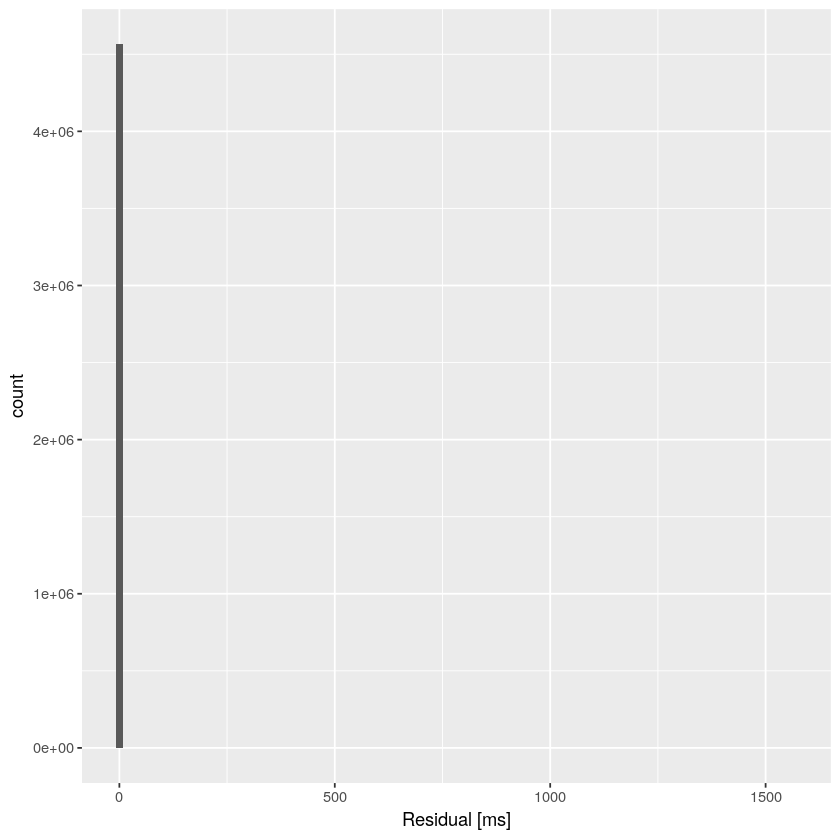

In [17]:
ggplot(data.table(`Residual [ms]`=model$residuals/1e9), aes(x=`Residual [ms]`)) +
    geom_histogram(bins=100)

Zoom in on the main mass of residuals.

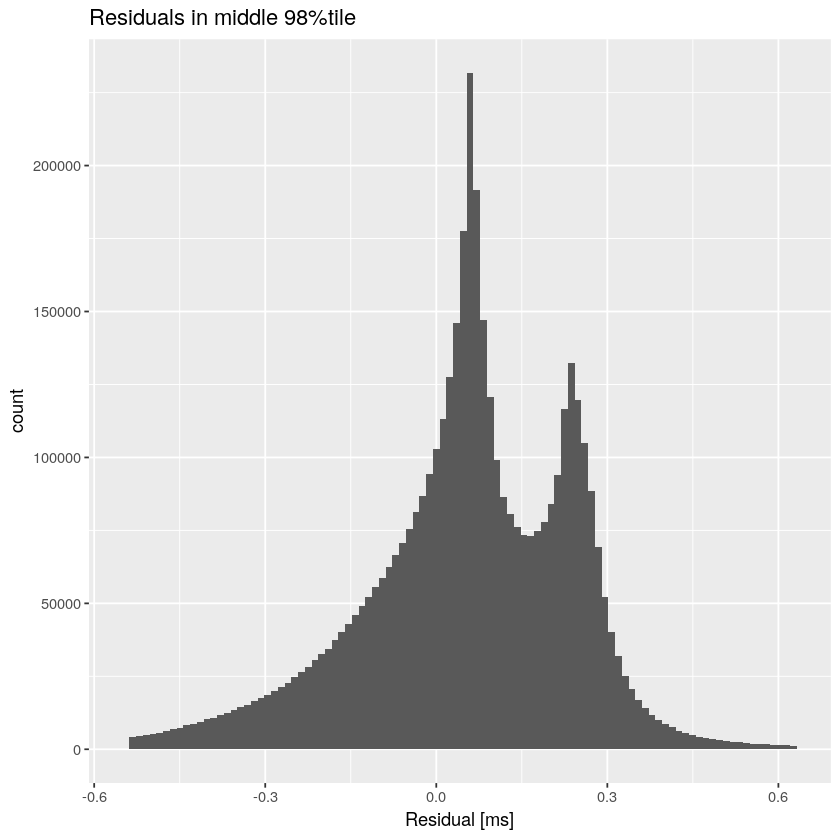

In [18]:
ggplot(
    data.table(`Residual [ms]`=model$residuals/1e9)[
        `Residual [ms]` >= quantile(model$residuals, 0.01)/1e9 &
        `Residual [ms]` <= quantile(model$residuals, 0.99)/1e9
    ], aes(x=`Residual [ms]`)
) +
    geom_histogram(bins=100) +
    ggtitle("Residuals in middle 98%tile")

This fit is better than nothing, and the result is `35 μs/tx + 2.8 ns/B + 5.2 μs/txin`.

## Analysis of `Apply`

The `Apply` operation includes everything.

In [19]:
model <- lm(
    `mut` ~ 0 + `unit_steps` + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`, `tx_outs`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=`apply_mut`*1e6
        )
    ]
)
model %>% summary


Call:
lm(formula = mut ~ 0 + unit_steps + txs + txs_size + tx_ins, 
    data = results[, .(txs, txs_size, tx_ins, tx_outs, unit_steps = as.numeric(unit_steps), 
        mut = apply_mut * 1e+06)])

Residuals:
       Min         1Q     Median         3Q        Max 
-3.935e+10 -2.500e+08  3.688e+08  1.217e+09  1.560e+12 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
unit_steps 6.334e-01  1.127e-03   561.9   <2e-16 ***
txs        1.564e+08  2.919e+05   535.7   <2e-16 ***
txs_size   4.763e+04  1.702e+02   279.9   <2e-16 ***
tx_ins     1.330e+07  5.017e+04   265.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.835e+09 on 4564826 degrees of freedom
Multiple R-squared:  0.7522,	Adjusted R-squared:  0.7522 
F-statistic: 3.464e+06 on 4 and 4564826 DF,  p-value: < 2.2e-16


The result, which is dominated by Plutus, is `0.63 ps/step + 0.16 ms/tx + 48 ns/B + 13 μs/txin`.

## Quantile regression

Repeat for the models above, but using quantile regression.

### Sample results

Quantile regression cannot handle a dataset as large as `results`, so work with a subset. Unfortunately, that subset has to be unsatisfactorily small in order ot make the problem computationally tractable.

In [20]:
someResults <- results[sample(1:nrow(results), 10000)]
someResults %>% summary

    slot_no             block_no           epoch_no     epoch_slot_no   
 Min.   : 65843520   Min.   : 7478307   Min.   :350.0   Min.   :   153  
 1st Qu.: 89373374   1st Qu.: 8620200   1st Qu.:404.0   1st Qu.:111441  
 Median :112828974   Median : 9762404   Median :458.0   Median :219819  
 Mean   :113080451   Mean   : 9777827   Mean   :458.9   Mean   :219069  
 3rd Qu.:137130194   3rd Qu.:10951182   3rd Qu.:515.0   3rd Qu.:325940  
 Max.   :161140909   Max.   :12134475   Max.   :570.0   Max.   :431930  
                                                                        
                                                            block_hash  
 0011163bc2f327432c3ff8619b7d12dcd45d99479c2a2994f64dbc8d2880a88c:   1  
 0017440808d2728cacefa962b37afe0e4df1d40b30b815e02f2be9106a226584:   1  
 0019390c30d583bc0bac16de63c9e3afd5b34d6d67761bb350bc21ce7bd990e0:   1  
 0019ef0b18340bca1750227b13d65f998c6b33d3fa9610af988dff1d189f2568:   1  
 0023c0c44b3c362bcd537ab2ce0c621ec7c6f5cacaf8ddd741

### `Apply - Reapply` at the 75th percentile

In [21]:
model <- rq(
    `mut` ~ 0 + `unit_steps` + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=(`apply_mut`-`reapply_mut`)*1e6
        )
    ],
    tau=0.75
)
model %>% summary

Warning message in summary.rq(.):
“270216 non-positive fis”



Call: rq(formula = mut ~ 0 + unit_steps + txs + txs_size + tx_ins, 
    tau = 0.75, data = results[, .(txs, txs_size, tx_ins, unit_steps = as.numeric(unit_steps), 
        mut = (apply_mut - reapply_mut) * 1e+06)])

tau: [1] 0.75

Coefficients:
           Value        Std. Error   t value      Pr(>|t|)    
unit_steps 9.559600e-01 8.600000e-04 1.107063e+03 0.000000e+00
txs        1.717824e+08 3.091690e+05 5.556262e+02 0.000000e+00
txs_size   1.586801e+04 9.550973e+01 1.661402e+02 0.000000e+00
tx_ins     1.765483e+07 1.151167e+05 1.533647e+02 0.000000e+00

The resulitng fit it `1.0 ps/step + 0.17 ms/tx + 16 ns/B + 1.8 μs/txin`.

### `Reapply` at the 75th percentile

In [22]:
model <- rq(
    `mut` ~ 0 + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`, `tx_outs`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=`reapply_mut`*1e6
        )
    ],
    tau=0.75
)
model %>% summary

Warning message in summary.rq(.):
“228797 non-positive fis”



Call: rq(formula = mut ~ 0 + txs + txs_size + tx_ins, tau = 0.75, data = results[, 
    .(txs, txs_size, tx_ins, tx_outs, unit_steps = as.numeric(unit_steps), 
        mut = reapply_mut * 1e+06)])

tau: [1] 0.75

Coefficients:
         Value        Std. Error   t value      Pr(>|t|)    
txs      4.248371e+07 3.400791e+04 1.249230e+03 0.000000e+00
txs_size 1.667426e+03 1.073172e+01 1.553737e+02 0.000000e+00
tx_ins   5.733642e+06 8.397012e+03 6.828194e+02 0.000000e+00

The resulitng fit it `43 ms/tx + 1.7 ns/B + 5.7 μs/txin`.

### `Apply` at the 75th percentile

In [23]:
model <- rq(
    `mut` ~ 0 + `unit_steps` + `txs` + `txs_size` + `tx_ins`, 
    results[
        , 
        .(
            `txs`, `txs_size`, `tx_ins`, `tx_outs`,
            `unit_steps`=as.numeric(`unit_steps`), 
            `mut`=`apply_mut`*1e6
        )
    ],
    tau=0.75
)
model %>% summary

Warning message in summary.rq(.):
“264040 non-positive fis”



Call: rq(formula = mut ~ 0 + unit_steps + txs + txs_size + tx_ins, 
    tau = 0.75, data = results[, .(txs, txs_size, tx_ins, tx_outs, 
        unit_steps = as.numeric(unit_steps), mut = apply_mut * 
            1e+06)])

tau: [1] 0.75

Coefficients:
           Value        Std. Error   t value      Pr(>|t|)    
unit_steps 9.719000e-01 9.400000e-04 1.038380e+03 0.000000e+00
txs        2.164329e+08 3.480589e+05 6.218284e+02 0.000000e+00
txs_size   1.591241e+04 9.828751e+01 1.618965e+02 0.000000e+00
tx_ins     2.252767e+07 1.277997e+05 1.762733e+02 0.000000e+00

The resulitng fit it `0.97 ps/step + 0.22 ms/tx + 16 ns/B + 23 μs/txin`.

## Findings

As previously discussed, the `db-analyser` is very noisy and hard to fit. Nevertheless, here are the best fits obtained using linear models and the quantile regression. Note that the quantile regression was based on a random subset of the data because it is not computationally feasible to perform quantile regression on such a large dataset in a reasonable amount of time.

| Regression      | Dependent variable |   Block size | Number of transactions | Number of transaction inputs | Number of Plutus steps |
| --------------- | ------------------ | -----------: | ---------------------: | ---------------------------: | ---------------------: |
| Simple ratio    | `Apply - Reapply`  |              |                        |                              |        `1.5e0 ps/step` |
| Linear model    | `Apply - Reapply`  | `4.7e4 ps/B` |          `2.3e8 ps/tx` |              `8.0e3 ps/txin` |       `6.1e-1 ps/step` |
|                 | `Reapply`          | `2.8e3 ps/B` |          `3.5e7 ps/tx` |              `5.2e6 ps/txin` |                        |
|                 | `Apply`            | `4.8e4 ps/B` |          `1.6e8 ps/tx` |              `1.3e7 ps/txin` |       `6.3e-1 ps/step` |
| 75th percentile | `Apply - Reapply`  | `1.6e4 ps/B` |          `1.7e8 ps/tx` |              `1.8e7 ps/txin` |       `9.6e-1 ps/step` |
|                 | `Reapply`          | `1.7e3 ps/B` |          `4.2e7 ps/tx` |              `5.7e6 ps/txin` |                        |
|                 | `Apply`            | `1.6e4 ps/B` |          `2.2e8 ps/tx` |              `2.3e7 ps/txin` |       `9.7e-1 ps/step` |

Coarsely, the "one picosecond per Plutus step" is a reasonable estimate for Plutus costs; we did not assess whether "eight bytes per Plutus memory unit" was also reasonable.